In [1]:
from importlib import reload
import tensorflow as tf
from utils_v2 import *

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
import BlueberryDQNAgent
reload(BlueberryDQNAgent)
from BlueberryDQNAgent import BlueberryDQNAgent

In [3]:
import datetime

In [9]:
agent = BlueberryDQNAgent(cash_supply=5000, epsilon_decay=0.9)

In [9]:
# features
agent.external_states

['USDT_BTC_high',
 'USDT_BTC_low',
 'USDT_BTC_close',
 'USDT_BTC_open',
 'USDT_BTC_weighted_mean',
 'USDT_BTC_volatility',
 'USDT_BTC_pctChange',
 'USDT_BTC_open_label',
 'USDT_BTC_pctChange_label',
 'USDT_BTC_volatility_label']

In [5]:
import matplotlib.pyplot as plt

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError ("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError ("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


def plot_test(start_time, end_time=None):

    if end_time is None: # default: one day
        end_time = agent.env.end_index
        
    df = agent.env.df
    df = df.loc[df.index >= start_time]
    df = df.loc[df.index <= end_time]
    prices = df['USDT_BTC_open']
#     print(prices.shape)
#     print(smooth(prices))
    
    actions = agent.test_actions
    actions = actions[actions.index >= start_time]
    actions = actions[actions.index < end_time]

    fig, ax1 = plt.subplots(figsize = (15, 8))

    ax1.plot(prices.index, prices, 'b-')
    ax1.set_ylabel('Price', color='b', fontsize=15)
    ax1.tick_params('y', colors='b', labelsize=15)

    hold = actions[actions == 1]
    buy = actions[actions == 2]
    sell = actions[actions == 0]


    
    sm =  smooth(prices,24)[12:len(prices.index)+12]
    import numpy as np
    from scipy.signal import argrelextrema

    local_minima = argrelextrema(sm,np.less) 
    local_maxima = argrelextrema(sm,np.greater)
    turning = np.concatenate((local_minima[0],local_maxima[0]),axis=0)
    turning = np.append(turning,0)
    turning = np.append(turning,len(prices.index) - 1)
    turning.sort()
    sell_first = True
    if (prices[0] < prices[1]):
        sell_first = False
    l_turning = list(turning)
    edge = []
    edge.append(0)
    for i in range(len(l_turning) - 1):
        edge.append((l_turning[i] + l_turning[i + 1])//2)
    edge.append(len(prices.index) - 1)
    
    good_action = []
    cur_action = 0 # sell
    last_edge = 0
    if (not sell_first):
        cur_action = 2 # buy
    for i in range(1,len(edge)):
        target_edge = edge[i]
        for j in np.arange(last_edge,target_edge,1):
            good_action.append(cur_action)
        cur_action = 2 - cur_action
        last_edge = target_edge
        
    good_action_df = pd.DataFrame()
    good_action_df["good_action"] = good_action
    good_action_df.index = actions.index


    
    good_buy = actions[(actions == 2) & (actions == good_action)]
    bad_buy = actions[(actions== 2) & (actions != good_action)]
    good_sell = actions[(actions == 0) & (actions == good_action)]
    bad_sell = actions[(actions== 0) & (actions != good_action)] 
        
    ax2 = ax1.twinx()
    ax2.scatter(hold.index, hold, c='blue', label='HOLD')
    ax2.scatter(good_buy.index, good_buy, c='green', marker = 'o',label='GOOD_BUY')
    ax2.scatter(bad_buy.index, bad_buy, c='red',marker = 'x', label='BAD_BUY')
    ax2.scatter(good_sell.index, good_sell, c='green', marker = 'o', label='GOOD_SELL')
    ax2.scatter(bad_sell.index, bad_sell, c='red', marker = 'x', label='BAD_SELL')
    ax2.set_yticks([])
    ax2.legend(loc=1, fontsize=15)
        
    
    ax3 = ax1.twinx()
    ax3.plot(prices.index,sm, 'r-')
    ax3.tick_params('y_smooth', colors='r', labelsize=15)
    ax3.set_yticks([])
    
    ax4 = ax1.twinx()
#     ax4.set_ylim(0,6000)
    ax4.plot(prices.index, agent.test_portfolio_values_cash, 'y', label='Cash Value')
    ax4.plot(prices.index, agent.test_portfolio_values_coin, 'orange', label='Coin Value in USD')
    ax4.legend(loc=4, fontsize=15)

    plt.xlim(actions.index[0], actions.index[-1])       

    plt.show()

# Set Experiment Name

In [6]:
experiment_name = 'Blueberry'

# Train (2017-12-01 ~ 2018-01-01)

In [53]:
agent.epsilon = 1
agent.epsilon_min = 0.005

In [10]:
train_start = datetime.datetime(2017,12,1,0)
train_end = datetime.datetime(2018,1,1,0)

sess = tf.Session()
agent.train(experiment_name=experiment_name, session=sess, start_time = train_start, \
            end_time = train_end, num_episodes=1000000, verbose=False, auto_save_and_load=False) # SHOULD USE MORE EPOCHS!!!

Auto loading is off. Creating model with fresh parameters.
Training, randomly selecting episodes from  2017-12-01 00:00:00  to 2018-01-01 00:00:00 :  ~ 31 days

episode memory len:  100
regression loss:  15112756.0
regression loss:  7870958.5
episode: 1/1000000, returns: 1.9e+01, epsilon: 0.9
episode memory len:  100
regression loss:  8463081.0
regression loss:  9294861.0
episode: 2/1000000, returns: 7.9, epsilon: 0.81
episode memory len:  100
regression loss:  702641.5
regression loss:  521682.4
episode: 3/1000000, returns: -0.06, epsilon: 0.73
episode memory len:  100
regression loss:  2885441.8
regression loss:  2041302.8
episode: 4/1000000, returns: 1.3, epsilon: 0.66
episode memory len:  100
regression loss:  2992319.8
regression loss:  1807708.6
episode: 5/1000000, returns: -6.7, epsilon: 0.59
episode memory len:  100
regression loss:  1403322.8
regression loss:  3602746.0
episode: 6/1000000, returns: 1.3e+01, epsilon: 0.53
episode memory len:  100
regression loss:  2896530.8
reg

episode memory len:  100
regression loss:  56.26897
regression loss:  25.41462
episode: 63/1000000, returns: 2.1, epsilon: 0.0013
episode memory len:  100
regression loss:  39.52668
regression loss:  80.87386
episode: 64/1000000, returns: -7.7, epsilon: 0.0012
episode memory len:  100
regression loss:  28.612314
regression loss:  45.053944
episode: 65/1000000, returns: 4.1, epsilon: 0.0011
episode memory len:  100
regression loss:  51.005894
regression loss:  71.66958
episode: 66/1000000, returns: 6.5, epsilon: 0.00096
episode memory len:  100
regression loss:  18.81812
regression loss:  48.005814
episode: 67/1000000, returns: -3.7, epsilon: 0.00096
episode memory len:  100
regression loss:  19.277603
regression loss:  32.686382
episode: 68/1000000, returns: 5.4, epsilon: 0.00096
episode memory len:  100
regression loss:  44.8494
regression loss:  57.5512
episode: 69/1000000, returns: 3.3, epsilon: 0.00096
episode memory len:  100
regression loss:  20.737051
regression loss:  24.042011

episode: 124/1000000, returns: -0.61, epsilon: 0.00096
episode memory len:  100
regression loss:  18.90548
regression loss:  12.054474
episode: 125/1000000, returns: 2.2, epsilon: 0.00096
episode memory len:  100
regression loss:  32.039516
regression loss:  39.634365
episode: 126/1000000, returns: -4.9, epsilon: 0.00096
episode memory len:  100
regression loss:  14.021626
regression loss:  11.04601
episode: 127/1000000, returns: 2.9, epsilon: 0.00096
episode memory len:  100
regression loss:  15.376619
regression loss:  9.238823
episode: 128/1000000, returns: 4.7, epsilon: 0.00096
episode memory len:  100
regression loss:  32.62863
regression loss:  49.606087
episode: 129/1000000, returns: -8.0, epsilon: 0.00096
episode memory len:  100
regression loss:  19.404839
regression loss:  5.909689
episode: 130/1000000, returns: 2.5, epsilon: 0.00096
episode memory len:  100
regression loss:  72.452705
regression loss:  180.14595
episode: 131/1000000, returns: 4.4, epsilon: 0.00096
episode me

KeyboardInterrupt: 

# Sanity check

In [46]:
agent.env.set_current_time(datetime.datetime(2017,12,1,0))

In [71]:
agent.env.step()
state = agent.env.getStatesSequence() + agent.portfolio.getStates()
agent.preprocess(state, agent.env.getCurrentPrice())
# state -= agent.state_mean
print(state[:10])

agent.model.predict(sess, state)

[0.9786733302950625, 0.9625740620772372, 0.9689382755383215, 0.9670969230609375, 0.9698057440451697, 0.004021565108977609, 0.0042499337197230425, 4.0, 5.0, 5.0]


array([[-24.864634 ,   4.5752234, -10.363736 ]], dtype=float32)

# Save Model (Optional)

In [35]:
agent.saver.save(sess, "./"+experiment_name+"/model.ckpt")

'./GreenTea/model.ckpt'

# Test on (2017-09-01 ~ 2018,1,1,0) Cheating...

In [72]:
test_start = datetime.datetime(2017,12,1,0)
test_end = datetime.datetime(2018,1,1,0)
agent.test(sess, start_time = test_start, end_time = test_end, verbose=True)

Testing from  2017-12-01 00:00:00  to 2018-01-01 00:00:00 :  ~ 31 days

Current time: 2017-12-01 00:00:00
Action start: Action.BUY , Total value before action: 5000.0
Before buying: coin:0.000, cash:5000.000, buy price:9740.005
After buying: coin bought:0.051, transaction fees:1.250, coin now:0.051, cash now:4498.750
Action end:  Action.BUY , Total value now: 4998.750.  , Return since entry: -0.025 %

Current time: 2017-12-02 00:00:00
Action start: Action.HOLD , Total value before action: 5158.645594831575
Action end:  Action.HOLD , Total value now: 5158.646.  , Return since entry: 3.173 %

Current time: 2017-12-03 00:00:00
Action start: Action.HOLD , Total value before action: 5153.850887520033
Action end:  Action.HOLD , Total value now: 5153.851.  , Return since entry: 3.077 %

Current time: 2017-12-04 00:00:00
Action start: Action.HOLD , Total value before action: 5227.740525128657
Action end:  Action.HOLD , Total value now: 5227.741.  , Return since entry: 4.555 %

Current time: 20

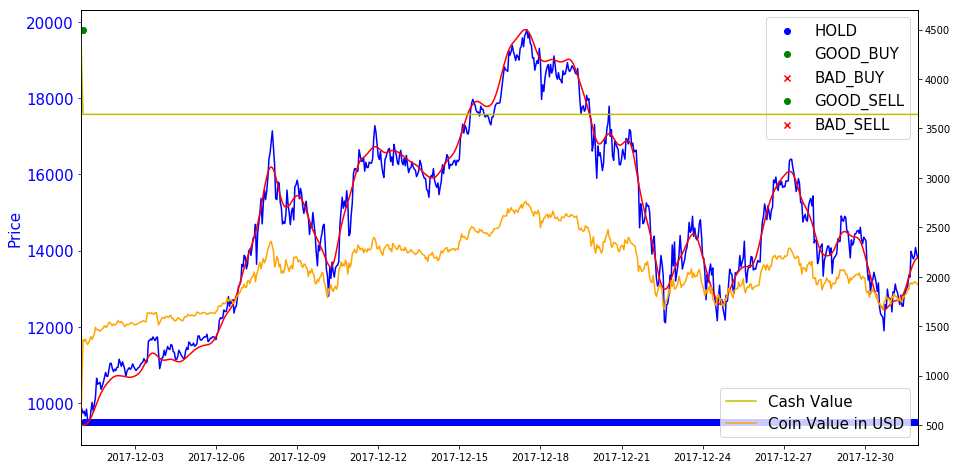

In [73]:
plot_test(test_start, test_end)

# Test on unseen time period (2018-01-01 ~ )

In [74]:
test_start = datetime.datetime(2018,1,1,0)
test_end = datetime.datetime(2018,4,11,0)
agent.test(sess, start_time = test_start, end_time = test_end, verbose=True)

Testing from  2018-01-01 00:00:00  to 2018-04-11 00:00:00 :  ~ 100 days

Current time: 2018-01-01 00:00:00
Action start: Action.BUY , Total value before action: 5000.0
Before buying: coin:0.000, cash:5000.000, buy price:13597.959
After buying: coin bought:0.037, transaction fees:1.250, coin now:0.037, cash now:4498.750
Action end:  Action.BUY , Total value now: 4998.750.  , Return since entry: -0.025 %

Current time: 2018-01-02 00:00:00
Action start: Action.HOLD , Total value before action: 5034.5092497516325
Action end:  Action.HOLD , Total value now: 5034.509.  , Return since entry: 0.690 %

Current time: 2018-01-03 00:00:00
Action start: Action.HOLD , Total value before action: 5131.84360721132
Action end:  Action.HOLD , Total value now: 5131.844.  , Return since entry: 2.637 %

Current time: 2018-01-04 00:00:00
Action start: Action.HOLD , Total value before action: 5161.1584658903175
Action end:  Action.HOLD , Total value now: 5161.158.  , Return since entry: 3.223 %

Current time:

Current time: 2018-02-12 00:00:00
Action start: Action.HOLD , Total value before action: 4433.244909764335
Action end:  Action.HOLD , Total value now: 4433.245.  , Return since entry: -11.335 %

Current time: 2018-02-13 00:00:00
Action start: Action.HOLD , Total value before action: 4530.19316308941
Action end:  Action.HOLD , Total value now: 4530.193.  , Return since entry: -9.396 %

Current time: 2018-02-14 00:00:00
Action start: Action.HOLD , Total value before action: 4485.509555180544
Action end:  Action.HOLD , Total value now: 4485.510.  , Return since entry: -10.290 %

Current time: 2018-02-15 00:00:00
Action start: Action.HOLD , Total value before action: 4597.369881888189
Action end:  Action.HOLD , Total value now: 4597.370.  , Return since entry: -8.053 %

Current time: 2018-02-16 00:00:00
Action start: Action.HOLD , Total value before action: 4715.4864848141815
Action end:  Action.HOLD , Total value now: 4715.486.  , Return since entry: -5.690 %

Current time: 2018-02-17 00:

Current time: 2018-03-29 00:00:00
Action start: Action.HOLD , Total value before action: 4393.630572342756
Action end:  Action.HOLD , Total value now: 4393.631.  , Return since entry: -12.127 %

Current time: 2018-03-30 00:00:00
Action start: Action.HOLD , Total value before action: 4231.362399646301
Action end:  Action.HOLD , Total value now: 4231.362.  , Return since entry: -15.373 %

Current time: 2018-03-31 00:00:00
Action start: Action.HOLD , Total value before action: 4255.1583015327315
Action end:  Action.HOLD , Total value now: 4255.158.  , Return since entry: -14.897 %

Current time: 2018-04-01 00:00:00
Action start: Action.HOLD , Total value before action: 4257.863897375
Action end:  Action.HOLD , Total value now: 4257.864.  , Return since entry: -14.843 %

Current time: 2018-04-02 00:00:00
Action start: Action.HOLD , Total value before action: 4258.110298706622
Action end:  Action.HOLD , Total value now: 4258.110.  , Return since entry: -14.838 %

Current time: 2018-04-03 00

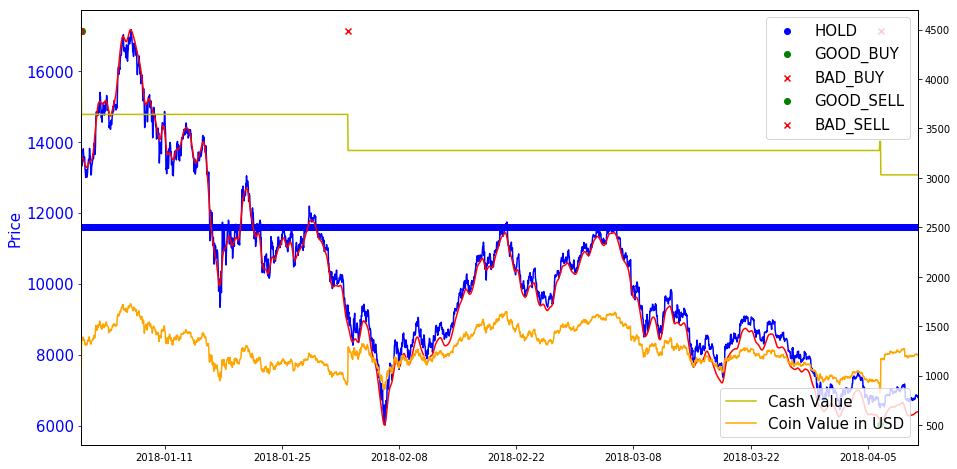

In [75]:
plot_test(test_start, test_end)

# Always buy agent

In [204]:
from simple_agents import *

In [205]:
always_buy_agent = AlwaysBuyAgent(Action)

In [206]:
env = Environment()
now = datetime.datetime(2017,12,1,0)
test_end = datetime.datetime(2018,1,1,0)
env.set_current_time(now)
portfolio = Portfolio(cash_supply=1e8)
while True:
    action = always_buy_agent.get_action()
    if (env.current_index - env.start_index) / env.time_delta % 24 == 0:
        verbose = True
        print('Current time:', env.current_index)
    else:
        verbose = False
    current_price = env.getCurrentPrice()
    action = portfolio.apply_action(current_price, action, verbose=verbose)
    is_done, state = env.step()
    if env.current_index == test_end:
        break
print("Initial cash supply:", portfolio.starting_cash)
print("Final holdings:", portfolio.getCurrentHoldings(env.getCurrentPrice()))

Current time: 2017-12-01 13:00:00
Action start: Action.BUY , Total value before action: 101768167.32603675
Before buying: coin:7583.457, cash:25327021.511, buy price:10218.013
After buying: coin bought:247.866, transaction fees:6331.755, coin now:7831.323, cash now:22787987.604
Action end:  Action.BUY , Total value now: 101727623.464.  , Return since entry: 1.728 %

Current time: 2017-12-02 13:00:00
Action start: Action.BUY , Total value before action: 109454130.3945612
Before buying: coin:9763.814, cash:2006821.046, buy price:11155.333
After buying: coin bought:17.990, transaction fees:501.705, coin now:9781.804, cash now:1805637.237
Action end:  Action.BUY , Total value now: 109450917.846.  , Return since entry: 9.451 %

Current time: 2017-12-03 13:00:00
Action start: Action.BUY , Total value before action: 114972193.9853586
Before buying: coin:9931.208, cash:159013.199, buy price:11719.152
After buying: coin bought:1.357, transaction fees:39.753, coin now:9932.564, cash now:143072.1

Current time: 2017-12-30 13:00:00
Action start: Action.BUY , Total value before action: 123570645.59934495
Before buying: coin:9944.905, cash:0.000, buy price:12595.667
After buying: coin bought:0.000, transaction fees:0.000, coin now:9944.905, cash now:0.000
Action end:  Action.BUY , Total value now: 123570645.599.  , Return since entry: 23.571 %

Current time: 2017-12-31 13:00:00
Action start: Action.BUY , Total value before action: 128366983.95875396
Before buying: coin:9944.905, cash:0.000, buy price:13084.562
After buying: coin bought:0.000, transaction fees:0.000, coin now:9944.905, cash now:0.000
Action end:  Action.BUY , Total value now: 128366983.959.  , Return since entry: 28.367 %

Initial cash supply: 100000000.0
Final holdings: 9944.90 coins, 0.00 cash, 136306457.98 current value, 36.31 percent returns
